In [1]:
resdir = "/usr/users/sbanerj/trans_eqtl_results/gtex_v8"
#resdir = "/scratch/sbanerj/trans-eqtl/dev-pipeline/gtex_v8"
tissuelist = ["aa"]
tejaas_preproc = "raw_std"
tejaas_method_variant = "permnull_sb0.1_knn"
rrfile = "rr.txt"
#chrmlist = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
chrmlist = [1]

In [2]:
import numpy as np
import pygtrie
from statsmodels.stats import multitest
import collections
import os

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24, colors = 'banskt', dpi = 72)

In [5]:
def read_tejaas(filename):
    rsidlist = list()
    bplist   = list()
    pvallist = list()
    qscorelist = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[1])
            pval = float(linesplit[5])
            qscore = float(linesplit[2])
            rsidlist.append(rsid)
            bplist.append(bppos)
            pvallist.append(pval)
            qscorelist.append(qscore)
    return rsidlist, pvallist, bplist, qscorelist

def read_tejaas_all_chrom(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    gwqvals = list()
    
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist, qlist = read_tejaas(filepath)
        gwrsids += rsids
        gwpvals += pvals
        gwqvals += qlist
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwpvals = np.array(gwpvals)
    
    ## Sanity check of p-value
    # Are there any nan p-values?
    nan_mask = np.isnan(gwpvals)
    if np.any(nan_mask):
        print(f'SNPs with nan p-value: {np.sum(nan_mask)}')
        gwpvals[np.where(nan_mask)[0]] = 1.0 ## just ignore this SNP
        
    # Are there any zero p-values
    zero_mask = gwpvals == 0
    if np.any(zero_mask):
        print(f'SNPs with zero p-value: {np.sum(zero_mask)}')
        gwpvals[np.where(zero_mask)[0]] = np.min(gwpvals[~zero_mask])    
    
    return gwrsids, gwnsnps, gwbppos, gwpvals, gwqvals

In [10]:
filefmt = f'{resdir}/{tissuelist[0]}/tejaas/{tejaas_preproc}/{tejaas_method_variant}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwbppos, gwpvals, gwqvals = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals = -np.log10(gwpvals)
gwqvals = np.array(gwqvals)

SNPs with zero p-value: 30


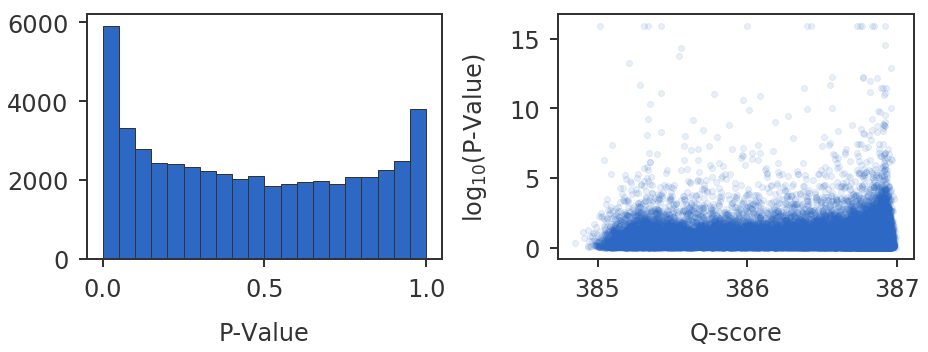

In [15]:
def simpleQQplot(ax, pvals, sample_size):
    N = len(pvals)
    y = -np.log10(np.sort(pvals[np.random.choice(N, size = sample_size, replace = False)]))
    x = -np.log10(np.arange(1, sample_size + 1) / sample_size)
    maxval = x[0] + 1
    ax.scatter(x, y)
    ax.plot([0, maxval], [0, maxval], ls = 'dashed')
    
def simpleQPplot(ax, pvals, qvals, sample_size):
    N = len(pvals)
    choose = np.random.choice(N, size = sample_size, replace = False)
    y = -np.log10(np.sort(pvals[choose]))
    x = qvals[choose]
    ax.scatter(x, y, alpha = 0.1)
    #ax.plot([0, maxval], [0, maxval], ls = 'dashed')   

fig = plt.figure(figsize = (13, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nplotsnp = min(50000, gwpvals.shape[0])
nchoose = np.sort(np.random.choice(gwpvals.shape[0], size = nplotsnp, replace = False))
ax1.hist(gwpvals[nchoose])
simpleQPplot(ax2, gwpvals, gwqvals, nplotsnp)

ax1.set_xlabel("P-Value")
ax2.set_xlabel("Q-score")
ax2.set_ylabel(r'$\log_{10}$(P-Value)')

plt.tight_layout()
outfile = f'../plots/gtex_v8_qscore_vs_pvalue.png'
plt.savefig(outfile, bbox_inches='tight')
plt.show()